## Classification of handwritten digits

*Fraida Fund*

In this notebook, we will explore the use of different techniques for classification of handwritten digits, with a focus on:

-   Classification accuracy (although we won’t do any hyperparameter tuning. It’s possible to improve the accuracy a lot using CV for hyperparameter tuning!)
-   How long it takes to train the model
-   How long it takes to make a prediction using the fitted model
-   Interpretability of the model

We will use the [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) `%time` to time how long it takes to fit the model and use the fitted model for predictions. It will tell us:

-   the CPU time (amount of time for which a CPU was working on this line of code)
-   the wall time (which also includes time waiting for I/O, etc.)

(Note that a related magic command, `%timeit`, tells us how long it takes to run multiple iterations of a line of code. This gives us a much more accurate estimate of the average time. However, since some of the commands we want to time will take a long time to run, we will use the basic `%time` command instead to save time.)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier


%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### Load the digits dataset

For this demo, we will use a dataset known as [MNIST](https://en.wikipedia.org/wiki/MNIST_database). It contains 70,000 samples of handwritten digits, size-normalized and centered in a fixed-size image. Each sample is represented as a 28x28 pixel array, so there are 784 features per samples.

We will start by loading the dataset using the `fetch_openml` function. This function allows us to retrieve a dataset by name from [OpenML](https://www.openml.org/), a public repository for machine learning data and experiments.

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


We observe that the data has 784 features and 70,000 samples:

In [3]:
X.shape

(70000, 784)

The target variables is a label for each digit: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9. There are between 6000 and 8000 samples for each class.

In [4]:
y.shape
print(y)
pd.Series(y).value_counts()

(70000,)

['5' '0' '4' ... '4' '5' '6']


1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
dtype: int64

We can see a few examples, by plotting the 784 features in a 28x28 grid:

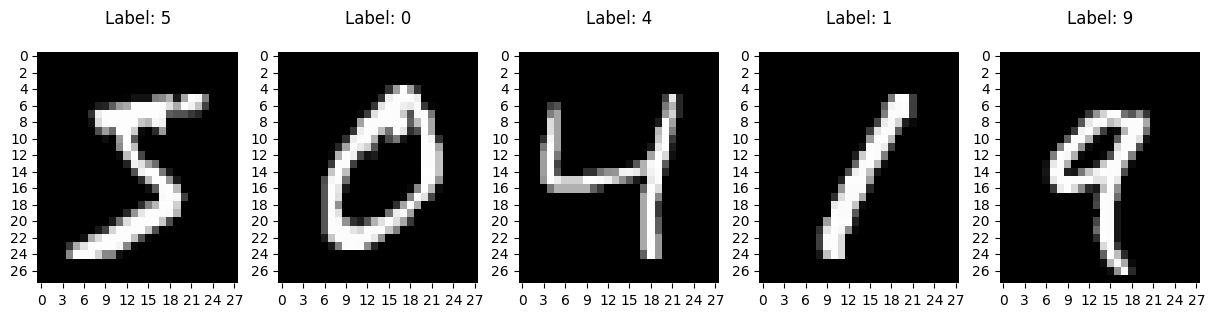

In [5]:
n_samples = 5
p = plt.figure(figsize=(n_samples*3,3));
for index, (image, label) in enumerate(zip(X[0:n_samples], y[0:n_samples])):
 p = plt.subplot(1, n_samples, index + 1);
 p = sns.heatmap(np.reshape(image, (28,28)), cmap=plt.cm.gray, cbar=False);
 p = plt.title('Label: %s\n' % label);

### Prepare data

Next, we will split our data into a test and training set using `train_test_split` from `sklearn.model_selection`.

Since the dataset is very large, it can take a long time to train a classifier on it. We just want to use it to demonstrate some useful concepts, so we will work with a smaller subset of the dataset. When we split the data using the `train_test_split` function, we will specify that we want 12,000 samples in the training set and 2,000 samples in the test set.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9,
                                     train_size=12000, test_size=2000)

We can also rescale the data:

In [7]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Train a classifier using logistic regression

Now we are ready to train a classifier. We will start with `sklearn`'s [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

We will time three commands:

-   The `fit` command trains the model (finds parameter estimates).
-   The `predict_proba` function uses the fitted logistic regression to get probabilities. For each sample, it returns 10 probabilities - one for each of the ten classes.
-   The `predict` function predicts a label for each sample in the test set. This will return the class label with the highest probability.

We will use the “magic command” `%time` to time how long it takes to execute each of these three commands. It will tell us:

-   the CPU time (amount of time for which a CPU was working on this line of code)
-   the wall time (which also includes time waiting for I/O, etc.)

In [8]:
cls_log = LogisticRegression(penalty='none',
                         tol=0.1, solver='saga',
                         multi_class='multinomial')
%time cls_log.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


CPU times: user 4.56 s, sys: 6.16 ms, total: 4.57 s
Wall time: 4.6 s


LogisticRegression(multi_class='multinomial', penalty='none', solver='saga',
                   tol=0.1)

In [9]:
%time y_pred_log = cls_log.predict(X_test)
%time y_pred_prob_log = cls_log.predict_proba(X_test)

CPU times: user 8.25 ms, sys: 6.99 ms, total: 15.2 ms
Wall time: 10.2 ms
CPU times: user 10.7 ms, sys: 2.98 ms, total: 13.7 ms
Wall time: 6.85 ms


In [10]:
acc = accuracy_score(y_test, y_pred_log)
acc

0.9135

Next, we will explore the results to see how the logistic regression classifier offers interpretability.

In [11]:
df_results_log = pd.DataFrame(y_pred_prob_log)
df_results_log = df_results_log.assign(y_pred = y_pred_log)
df_results_log = df_results_log.assign(y_true = y_test)
df_results_log = df_results_log.assign(correct = y_test==y_pred_log)

df_mis_log = df_results_log[df_results_log['correct']==False]
df_mis_log = df_mis_log.reset_index()

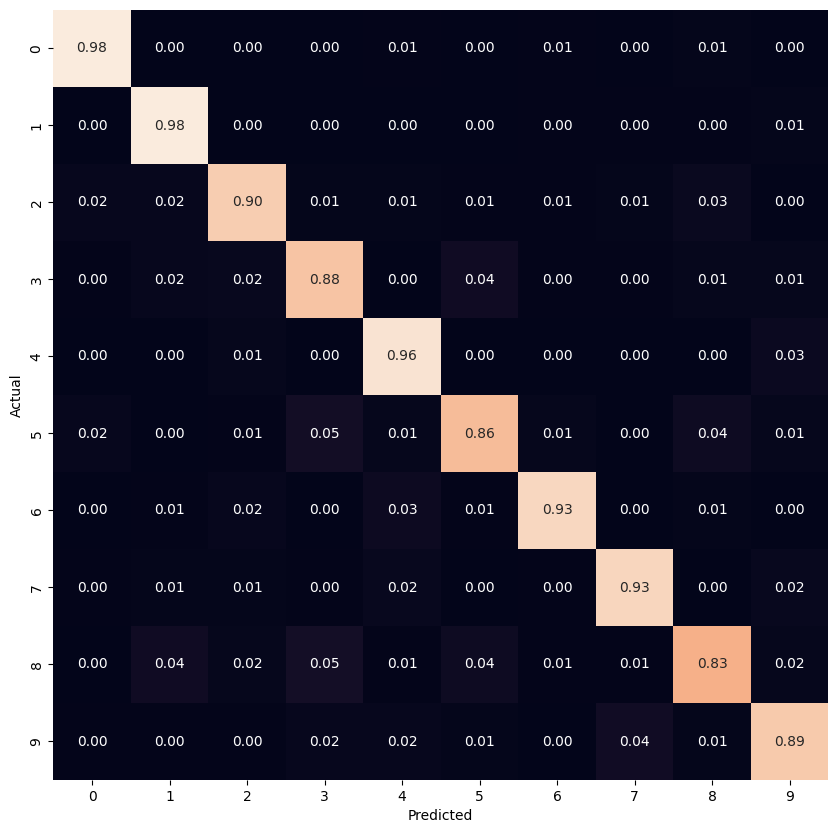

In [12]:
confusion_matrix = pd.crosstab(df_results_log['y_true'], df_results_log['y_pred'],
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cbar=False)

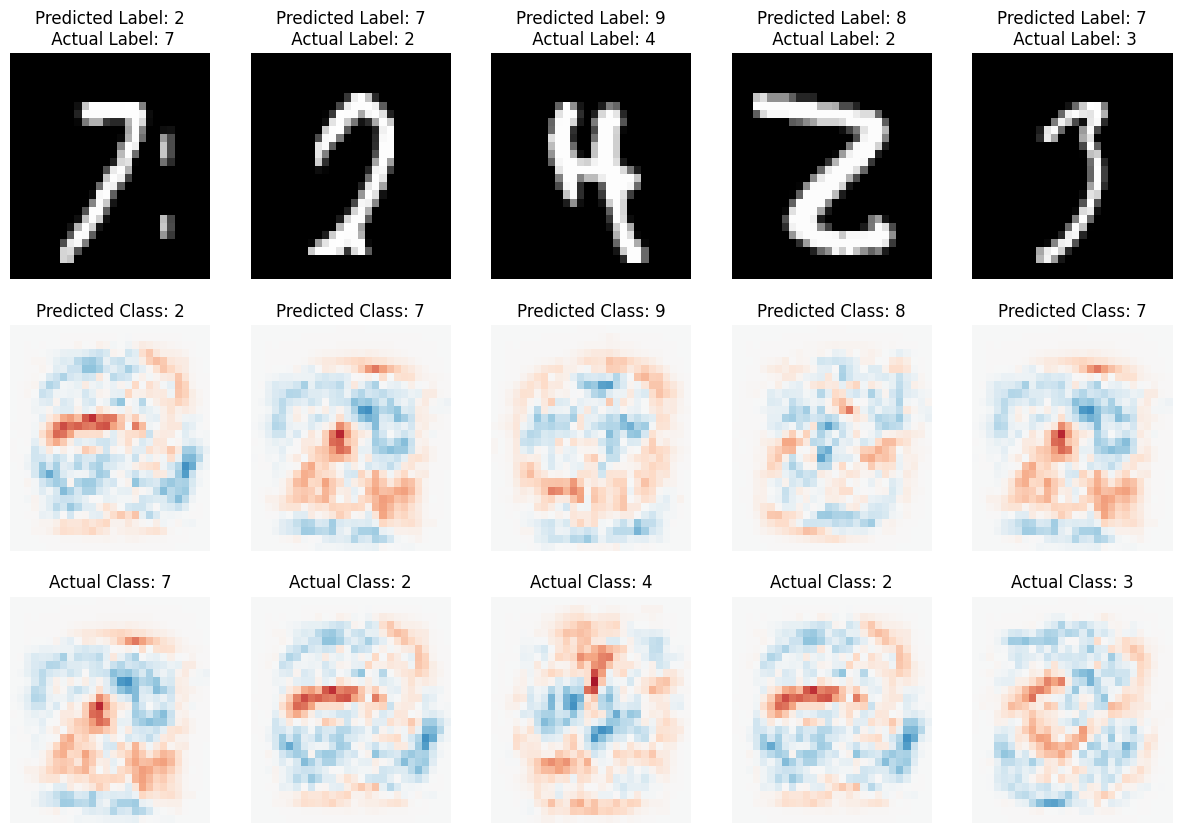

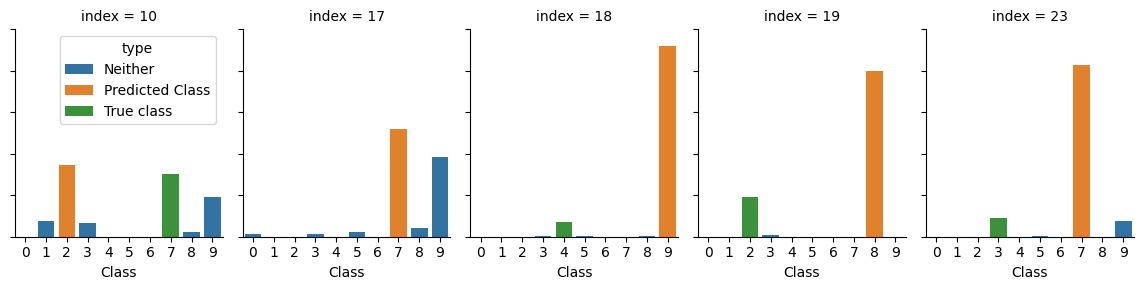

In [13]:
scale = 1
idx_mis = df_mis_log['index']
n_samples = min(5,len(idx_mis))
n_vectors = 2
p = plt.figure(figsize=(3*n_samples,5*n_vectors));
for index in range(n_samples):
  sample_index = idx_mis[index]
  image = X_test[sample_index]
  true_label = y_test[sample_index]
  pred_label = y_pred_log[sample_index]
  p = plt.subplot(1+n_vectors, n_samples, index + 1);
  p = sns.heatmap(np.reshape(image, (28,28)), cmap=plt.cm.gray,
                    xticklabels=False, yticklabels=False, cbar=False);
  p = plt.title('Predicted Label: %s\n Actual Label: %s' %
                (pred_label, true_label));

  p = plt.subplot(1+n_vectors, n_samples, (1)*n_samples + (index+1));
  p = sns.heatmap(cls_log.coef_[int(pred_label)].reshape(28, 28),
                cmap=plt.cm.RdBu, vmin=-scale, vmax=scale,
                xticklabels=False, yticklabels=False, cbar=False);
  p = plt.title('Predicted Class: %s' % pred_label)

  p = plt.subplot(1+n_vectors, n_samples, (2)*n_samples + (index+1));
  p = sns.heatmap(cls_log.coef_[int(true_label)].reshape(28, 28),
                cmap=plt.cm.RdBu, vmin=-scale, vmax=scale,
                xticklabels=False, yticklabels=False, cbar=False);
  p = plt.title('Actual Class: %s' % true_label)



df_mis_melt = pd.melt(df_mis_log, id_vars=['y_pred','y_true','correct', 'index'],
                      var_name='class', value_name='probability')
df_mis_melt = df_mis_melt.sort_values(by='index')
df_mis_melt['type'] = np.select([df_mis_melt['class'].astype(float)==df_mis_melt['y_pred'].astype(float),
                         df_mis_melt['class'].astype(float)==df_mis_melt['y_true'].astype(float)],
                        ['Predicted Class', 'True class'], default='Neither')

p = sns.catplot(data=df_mis_melt.head(n=n_samples*10), col="index", hue='type',
                x="class", y="probability",kind="bar",
                dodge=False, legend_out=False, height=3, aspect=0.8);
p.set_axis_labels("Class", "");
plt.ylim(0,1);
p.set_yticklabels();

### Train a classifier using K Nearest Neighbor

Next, we will use `sklearn`'s [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [14]:
cls_knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
%time cls_knn.fit(X_train, y_train)

CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 19 ms


KNeighborsClassifier(n_neighbors=3, weights='distance')

In [15]:
%time y_pred_knn = cls_knn.predict(X_test)
%time y_pred_prob_knn = cls_knn.predict_proba(X_test)

CPU times: user 2.59 s, sys: 12.6 ms, total: 2.61 s
Wall time: 1.38 s
CPU times: user 2.55 s, sys: 9.33 ms, total: 2.56 s
Wall time: 1.68 s


In [16]:
acc = accuracy_score(y_test, y_pred_knn)
acc

0.9595

In [17]:
df_results_knn = pd.DataFrame(y_pred_prob_knn)
df_results_knn = df_results_knn.assign(y_pred = y_pred_knn)
df_results_knn = df_results_knn.assign(y_true = y_test)
df_results_knn = df_results_knn.assign(correct = y_test==y_pred_knn)

df_mis_knn = df_results_knn[df_results_knn['correct']==False]
df_mis_knn = df_mis_knn.reset_index()

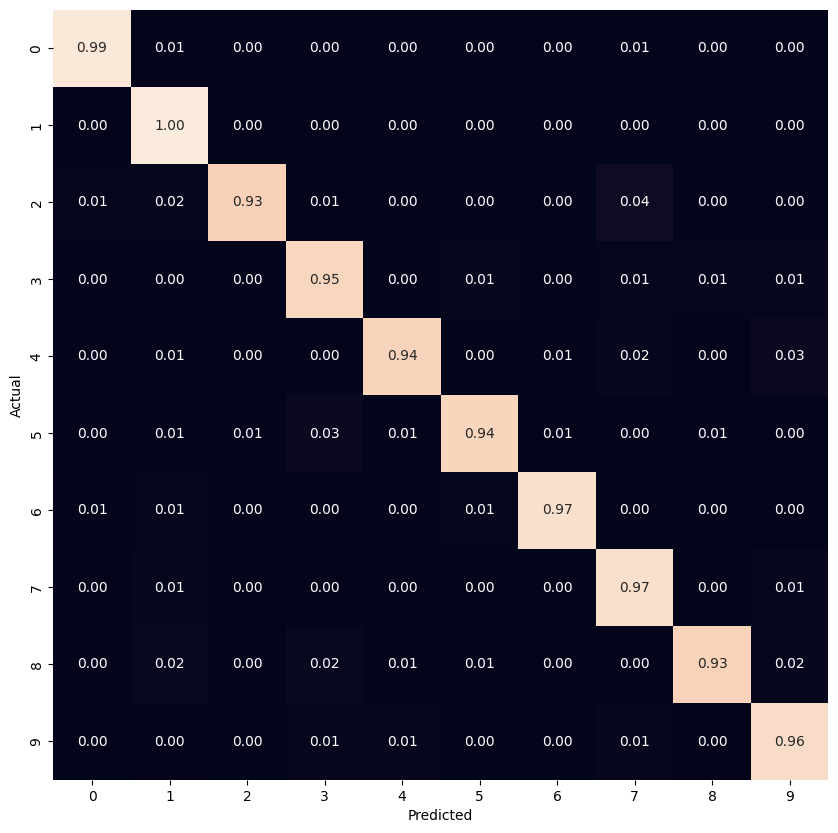

In [18]:
confusion_matrix = pd.crosstab(df_results_knn['y_true'], df_results_knn['y_pred'],
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cbar=False)

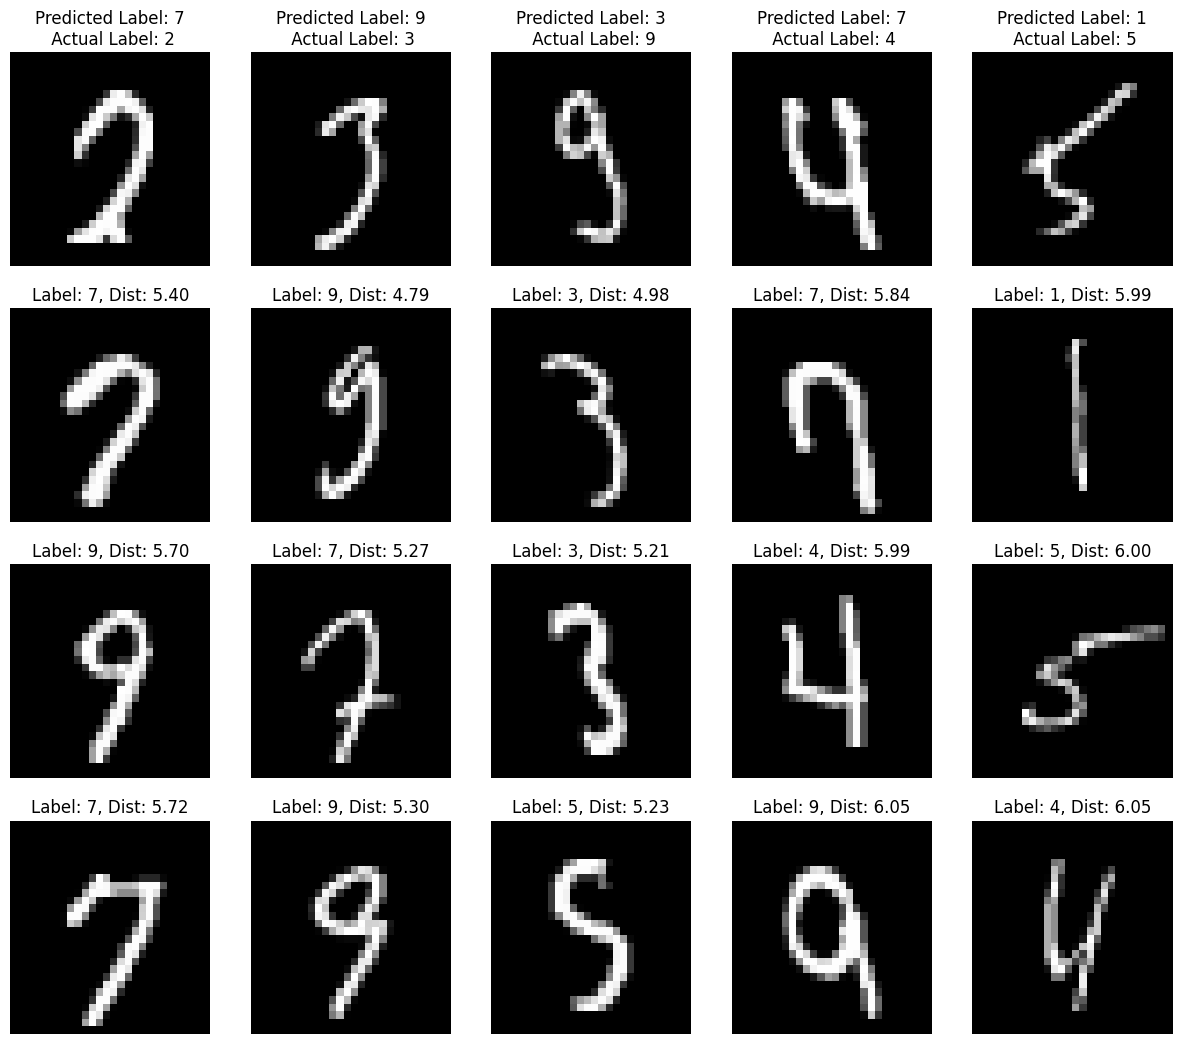

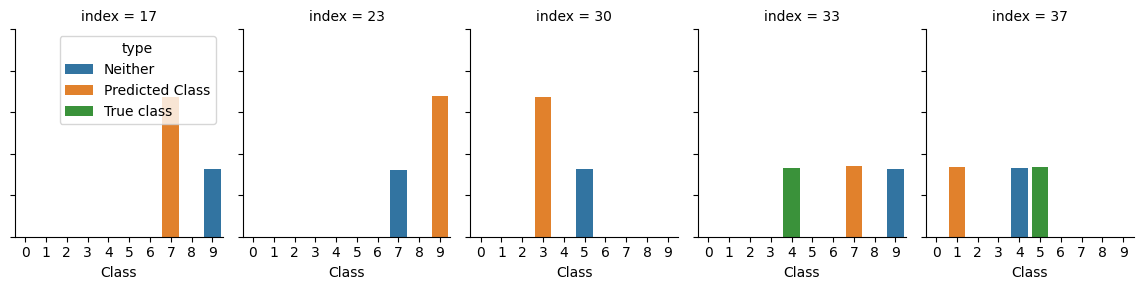

In [19]:
distances_mis, neighbor_idx_mis = cls_knn.kneighbors(X_test[df_mis_knn['index']])

idx_mis = df_mis_knn['index']
n_samples = min(5,len(idx_mis))
n_neighbors = 3
p = plt.figure(figsize=(3*n_samples,4.25*n_neighbors));
for index in range(n_samples):
  sample_index = idx_mis[index]
  image = X_test[sample_index]
  true_label = y_test[sample_index]
  pred_label = y_pred_knn[sample_index]
  p = plt.subplot(1+n_neighbors, n_samples, index + 1);
  p = sns.heatmap(np.reshape(image, (28,28)), cmap=plt.cm.gray,
                    xticklabels=False, yticklabels=False, cbar=False);
  p = plt.title('Predicted Label: %s\n Actual Label: %s' %
                (pred_label, true_label));
  for i in range(n_neighbors):
    neighbor_index = neighbor_idx_mis[index][i]
    neighbor_image = X_train[neighbor_index]
    true_label = y_train[neighbor_index]
    dist = distances_mis[index][i]
    p = plt.subplot(1+n_neighbors, n_samples, (1+i)*n_samples + (index+1));
    p = sns.heatmap(np.reshape(neighbor_image, (28,28)), cmap=plt.cm.gray,
                    xticklabels=False, yticklabels=False, cbar=False);
    p = plt.title('Label: %s, Dist: %s' %
                (true_label, "{:.2f}".format(dist)));

df_mis_melt = pd.melt(df_mis_knn, id_vars=['y_pred','y_true','correct', 'index'],
                      var_name='class', value_name='probability')
df_mis_melt = df_mis_melt.sort_values(by='index')
df_mis_melt['type'] = np.select([df_mis_melt['class'].astype(float)==df_mis_melt['y_pred'].astype(float),
                         df_mis_melt['class'].astype(float)==df_mis_melt['y_true'].astype(float)],
                        ['Predicted Class', 'True class'], default='Neither')

p = sns.catplot(data=df_mis_melt.head(n=n_samples*10), col="index", hue='type', dodge=False,
                x="class", y="probability",kind="bar", legend_out=False, height=3, aspect=0.8);
p.set_axis_labels("Class", "");
plt.ylim(0,1);
p.set_yticklabels();

### Train a classifier using Decision Tree

Next, we will use `sklearn`'s [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [20]:
cls_dt = DecisionTreeClassifier()
%time cls_dt.fit(X_train, y_train)

CPU times: user 2.67 s, sys: 17.1 ms, total: 2.69 s
Wall time: 2.69 s


DecisionTreeClassifier()

In [21]:
%time y_pred_dt = cls_dt.predict(X_test)
%time y_pred_prob_dt = cls_dt.predict_proba(X_test)

CPU times: user 5.13 ms, sys: 0 ns, total: 5.13 ms
Wall time: 4.38 ms
CPU times: user 4.85 ms, sys: 0 ns, total: 4.85 ms
Wall time: 3.43 ms


In [22]:
acc = accuracy_score(y_test, y_pred_dt)
acc

0.797

In [23]:
df_results_dt = pd.DataFrame(y_pred_prob_dt)
df_results_dt = df_results_dt.assign(y_pred = y_pred_dt)
df_results_dt = df_results_dt.assign(y_true = y_test)
df_results_dt = df_results_dt.assign(correct = y_test==y_pred_dt)

df_mis_dt = df_results_dt[df_results_dt['correct']==False]
df_mis_dt = df_mis_dt.reset_index()

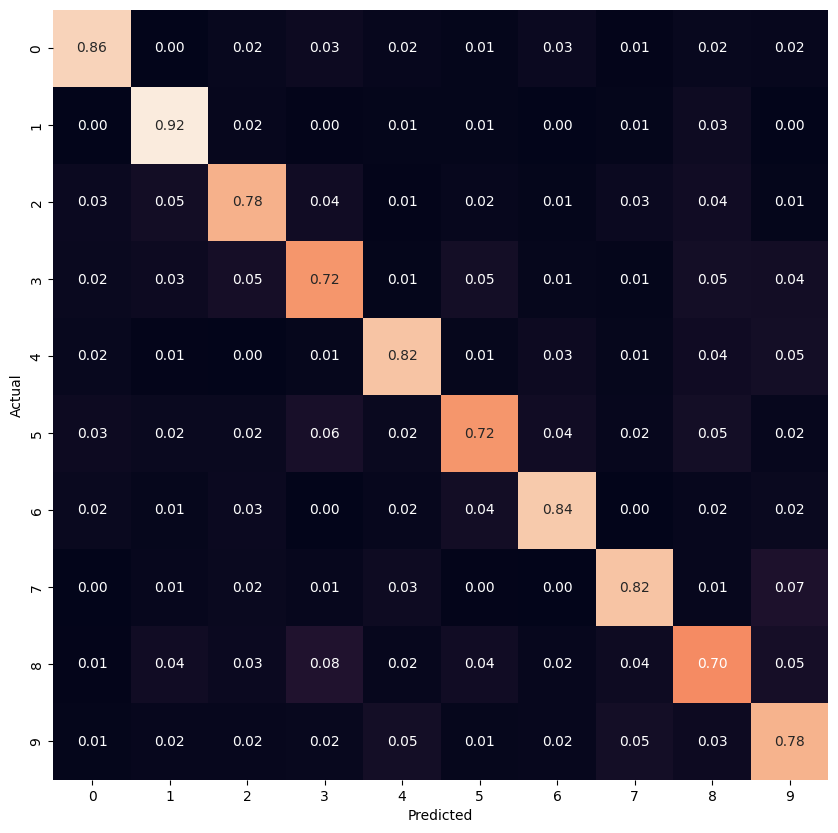

In [24]:
confusion_matrix = pd.crosstab(df_results_dt['y_true'], df_results_dt['y_pred'],
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cbar=False)

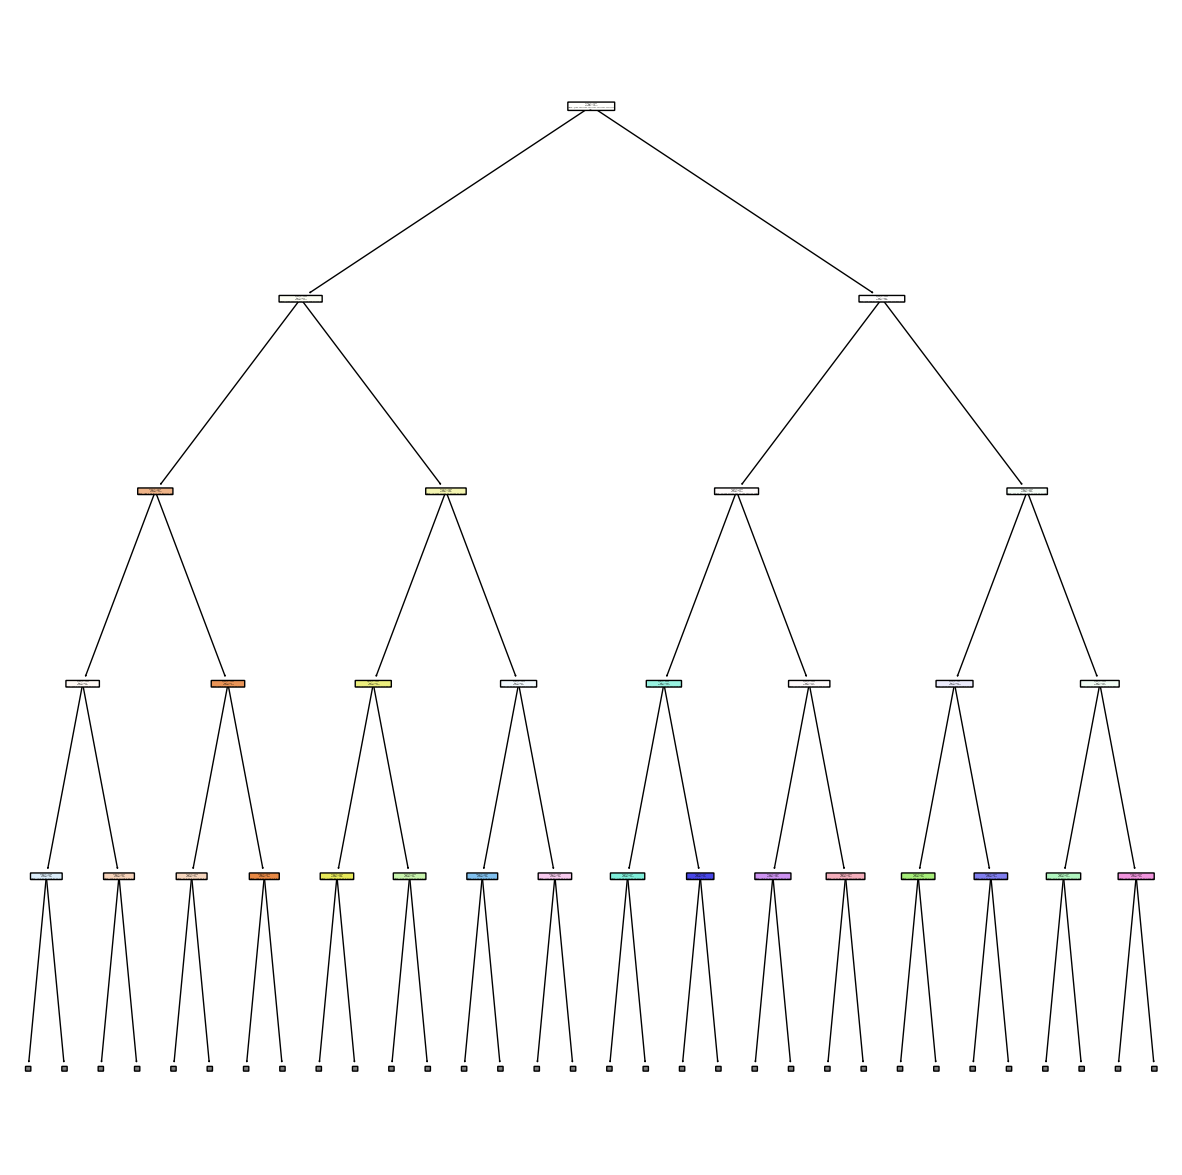

In [25]:
p = plt.figure(figsize=(15,15));
p = plot_tree(cls_dt, max_depth=4, filled=True, rounded=True);

Here's a better way to plot a large tree:

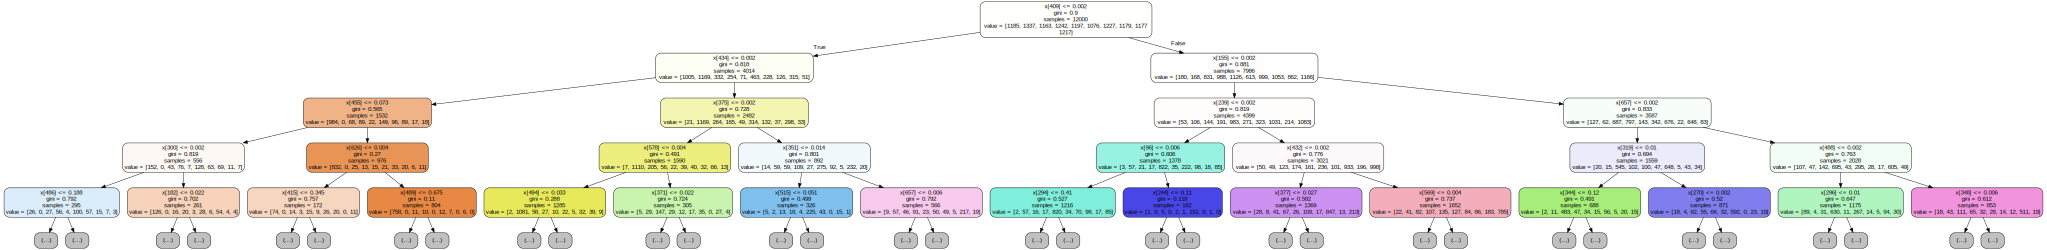

In [26]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(cls_dt, out_file=None,
                      max_depth=4,
                     filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

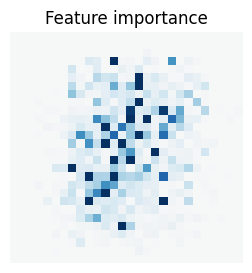

In [27]:
scale_dt = 0.01
p = plt.figure(figsize=(3,3));
p = sns.heatmap(cls_dt.feature_importances_.reshape(28, 28),
              cmap=plt.cm.RdBu, vmin=-scale_dt, vmax=scale_dt,
              xticklabels=False, yticklabels=False, cbar=False);
p = plt.title('Feature importance')

### Train an ensemble of trees

Next, we will train some ensembles of trees using two different approaches:

-   **Bagging**, where we train many independent trees and average their output. We will attempt “regular” bagging, and also a random forest, which uses decorrelated trees.
-   **Boosting**, where we iteratively train trees to focus on the “difficult” samples that were misclassified by previous trees.

In [28]:
cls_bag = BaggingClassifier(DecisionTreeClassifier())
%time cls_bag.fit(X_train, y_train)

CPU times: user 17.2 s, sys: 174 ms, total: 17.4 s
Wall time: 17.4 s


BaggingClassifier(estimator=DecisionTreeClassifier())

In [29]:
%time y_pred_bag = cls_bag.predict(X_test)
%time y_pred_prob_bag = cls_bag.predict_proba(X_test)

CPU times: user 66 ms, sys: 3 ms, total: 69 ms
Wall time: 68.2 ms
CPU times: user 64.4 ms, sys: 8 µs, total: 64.4 ms
Wall time: 62.6 ms


In [30]:
acc = accuracy_score(y_test, y_pred_bag)
acc

0.91

In [31]:
cls_rf = RandomForestClassifier()
%time cls_rf.fit(X_train, y_train)

CPU times: user 6.77 s, sys: 30.1 ms, total: 6.8 s
Wall time: 6.78 s


RandomForestClassifier()

In [32]:
%time y_pred_rf = cls_rf.predict(X_test)
%time y_pred_prob_rf = cls_rf.predict_proba(X_test)

CPU times: user 71.9 ms, sys: 2.96 ms, total: 74.8 ms
Wall time: 77.1 ms
CPU times: user 71.5 ms, sys: 0 ns, total: 71.5 ms
Wall time: 72.4 ms


In [33]:
acc = accuracy_score(y_test, y_pred_rf)
acc

0.959

In [34]:
cls_ab = AdaBoostClassifier()
%time cls_ab.fit(X_train, y_train)

CPU times: user 14.7 s, sys: 746 ms, total: 15.4 s
Wall time: 15.5 s


AdaBoostClassifier()

In [35]:
%time y_pred_ab = cls_ab.predict(X_test)
%time y_pred_prob_ab = cls_ab.predict_proba(X_test)

CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 200 ms
CPU times: user 183 ms, sys: 0 ns, total: 183 ms
Wall time: 185 ms


In [36]:
acc = accuracy_score(y_test, y_pred_ab)
acc

0.692

In [37]:
# Faster than regular GradientBoostingClassifier
# but, still takes several minutes

cls_gradboost = HistGradientBoostingClassifier()
%time cls_gradboost.fit(X_train, y_train)

CPU times: user 3min 34s, sys: 44.1 s, total: 4min 18s
Wall time: 2min 24s


HistGradientBoostingClassifier()

In [38]:
%time y_pred_gradboost = cls_gradboost.predict(X_test)
%time y_pred_prob_gradboost = cls_gradboost.predict_proba(X_test)

CPU times: user 566 ms, sys: 1.03 ms, total: 567 ms
Wall time: 292 ms
CPU times: user 549 ms, sys: 3.05 ms, total: 552 ms
Wall time: 296 ms


In [39]:
acc = accuracy_score(y_test, y_pred_gradboost)
acc

0.9595

### Train a linear support vector classifier

The next classifier we’ll attempt is a support vector classifier.

In [40]:
cls_svc = SVC(kernel='linear')
%time cls_svc.fit(X_train, y_train)

CPU times: user 8.28 s, sys: 44.8 ms, total: 8.33 s
Wall time: 8.31 s


SVC(kernel='linear')

In [41]:
%time y_pred_svc = cls_svc.predict(X_test)
# note: there is no predict_proba for SVC

CPU times: user 2.42 s, sys: 1.65 ms, total: 2.43 s
Wall time: 2.47 s


In [42]:
acc = accuracy_score(y_test, y_pred_svc)
acc

0.919

In [43]:
df_results_svc = pd.DataFrame(y_pred_svc)
df_results_svc = df_results_svc.assign(y_pred = y_pred_svc)
df_results_svc = df_results_svc.assign(y_true = y_test)
df_results_svc = df_results_svc.assign(correct = y_test==y_pred_svc)

df_mis_svc = df_results_svc[df_results_svc['correct']==False]
df_mis_svc = df_mis_svc.reset_index()

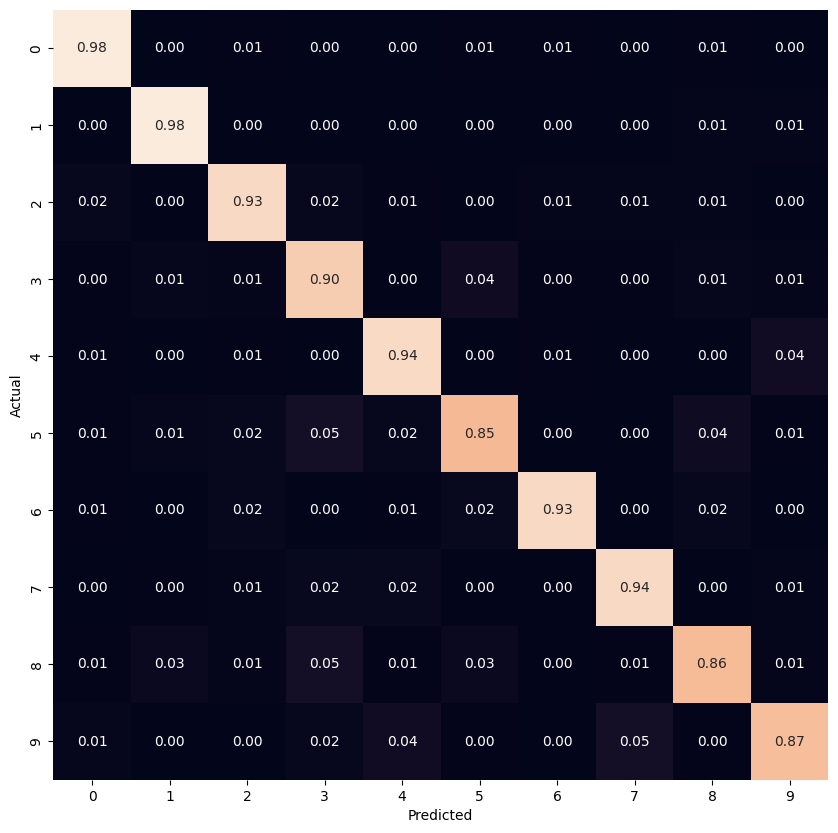

In [44]:
confusion_matrix = pd.crosstab(df_results_svc['y_true'], df_results_svc['y_pred'],
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cbar=False)

The decisions of the SVC are a little bit more complicated to interpret, but we can get some insight by looking at the support vectors.

First, we can find out the number of support vectors for each class, and get their indices:

In [45]:
idx_support = cls_svc.support_
cls_svc.n_support_

array([192, 187, 329, 383, 328, 401, 244, 298, 389, 386], dtype=int32)

Then, we can plot a random subset of support vectors for each class:

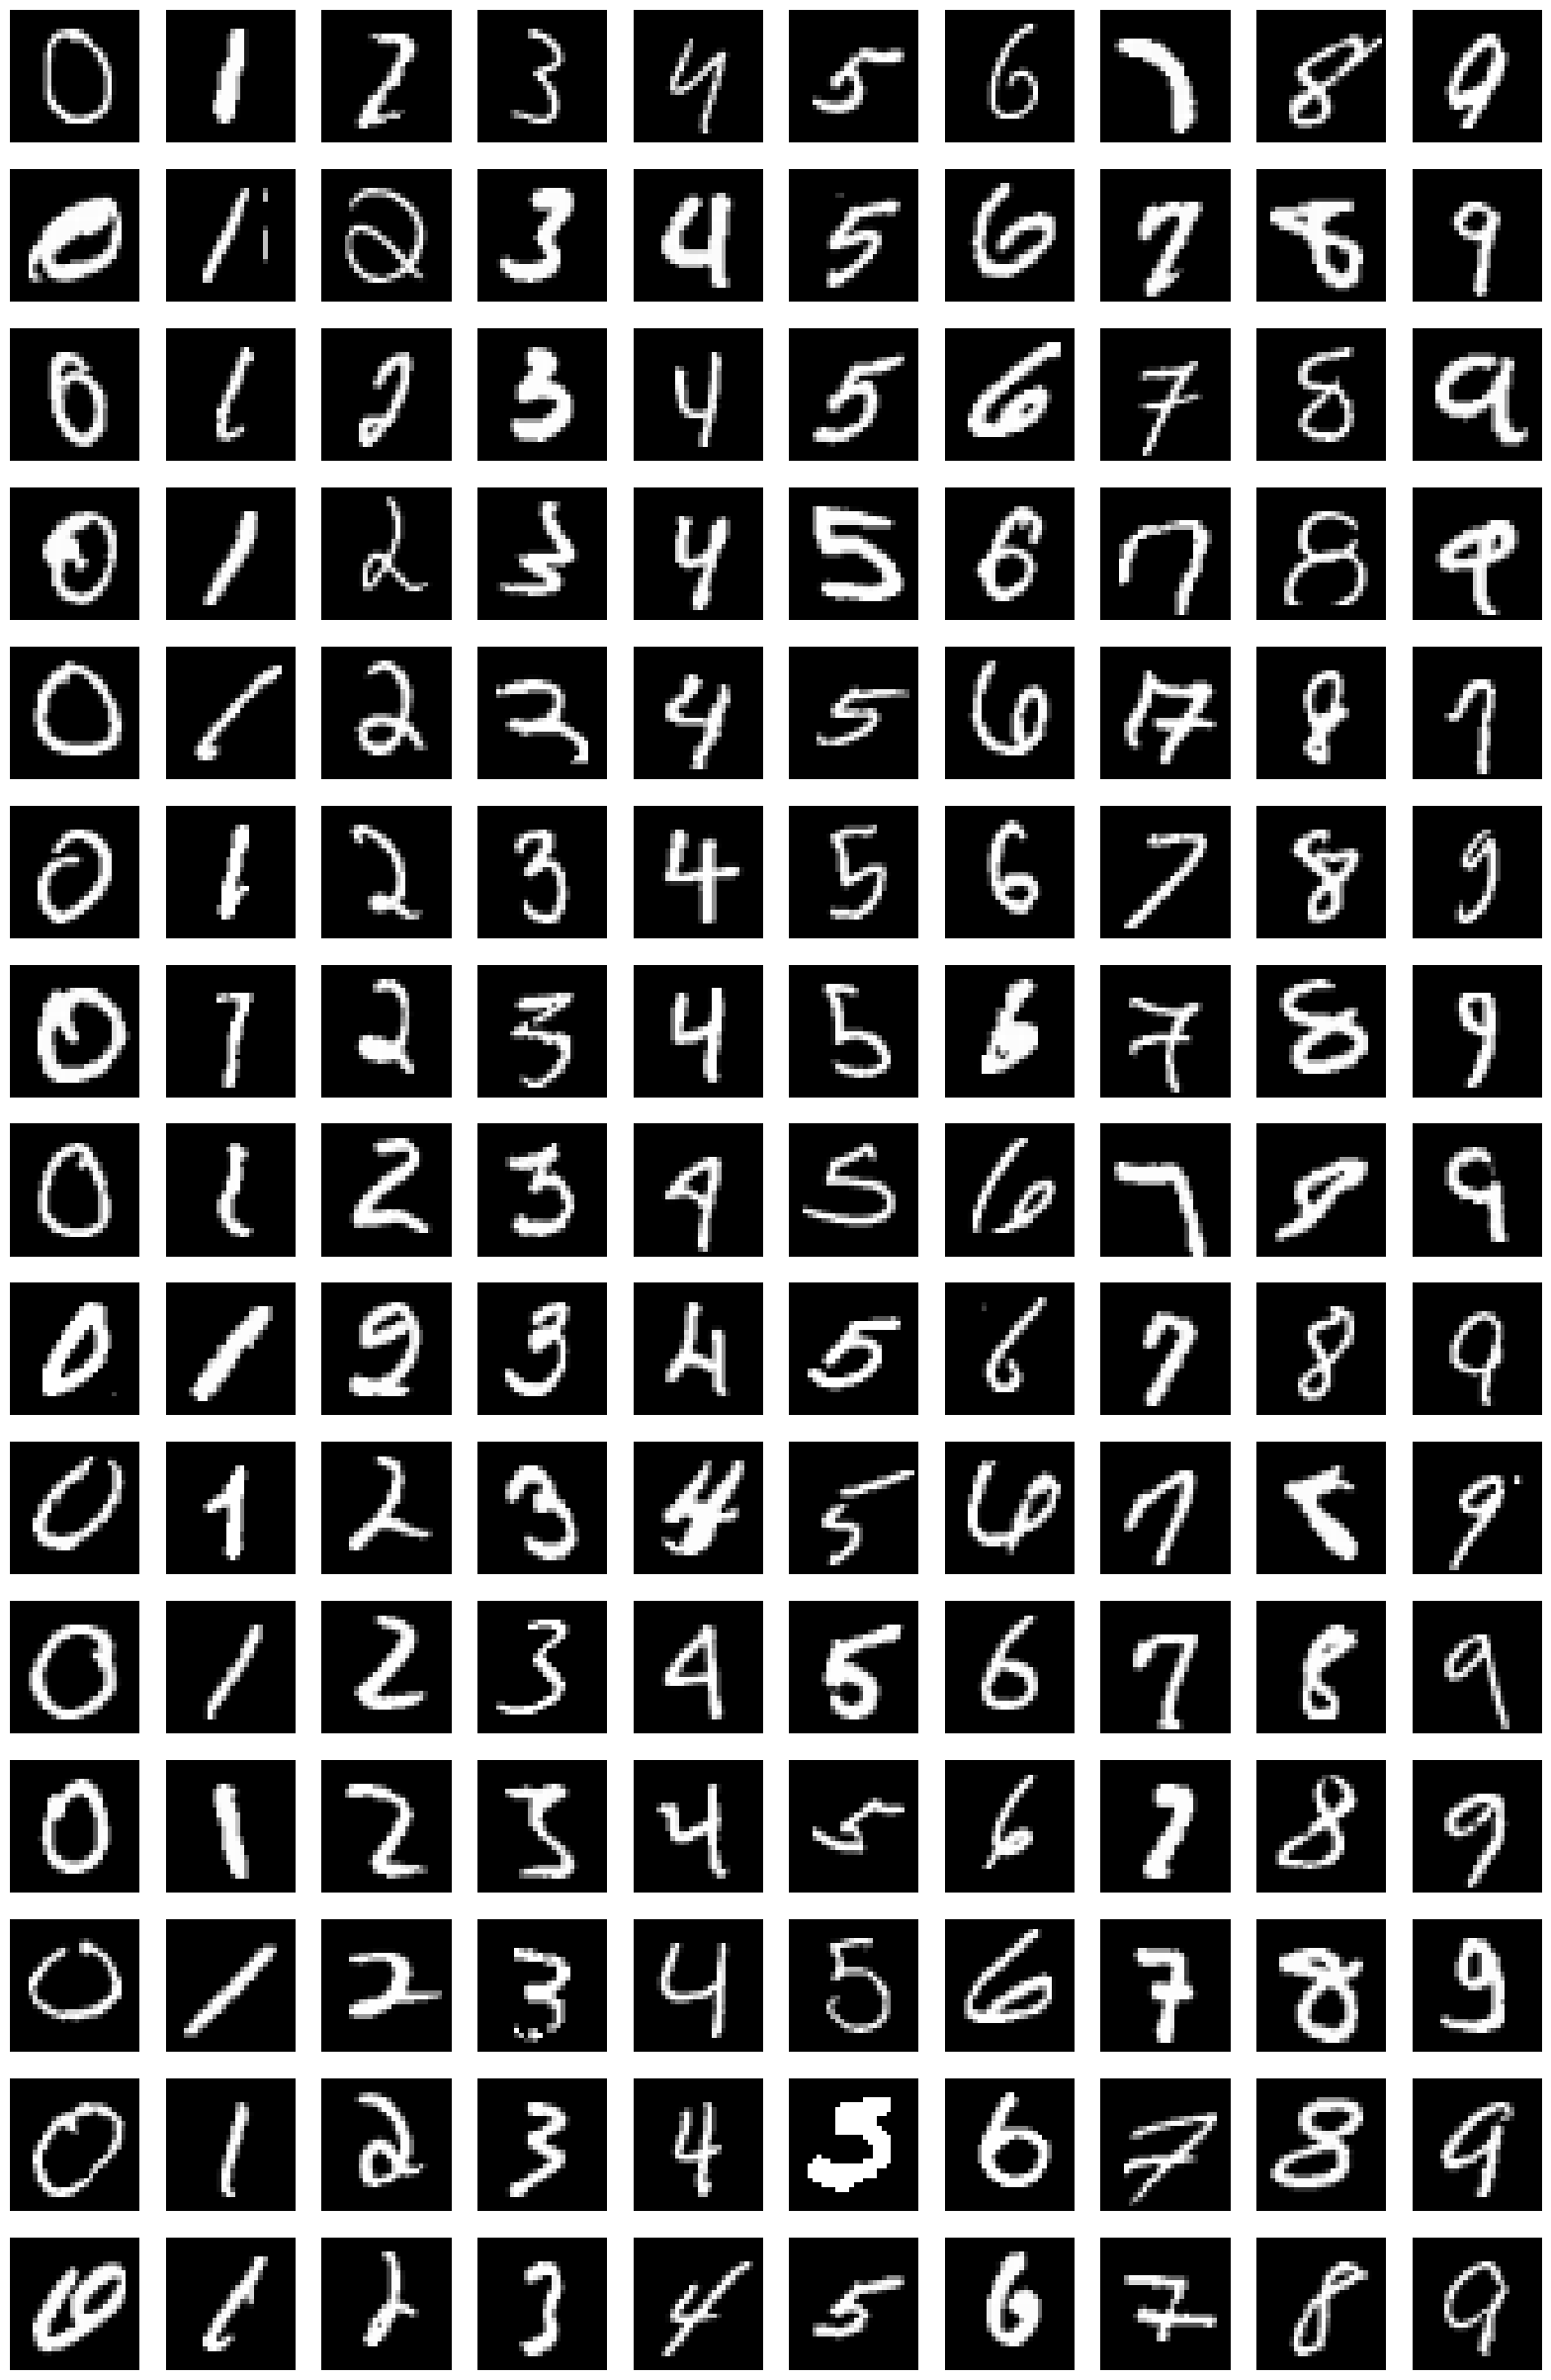

In [46]:
num_classes = len(cls_svc.classes_)
m = np.insert(np.cumsum(cls_svc.n_support_), 0, 0)
samples_per_class = 15
figure = plt.figure(figsize=(num_classes*2,(1+samples_per_class*2)));
for y, cls in enumerate(cls_svc.classes_):
  idxs = np.random.choice(idx_support[m[y]:m[y+1]], samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + y + 1
    p = plt.subplot(samples_per_class, num_classes, plt_idx);
    p = sns.heatmap(np.reshape(X_train[idx], (28,28)), cmap=plt.cm.gray,
             xticklabels=False, yticklabels=False, cbar=False);
    p = plt.axis('off');

You may notice that the support vectors include many atypical examples of the digits they represent.

Equivalently, the support vectors include examples that are more likely than most training samples to be confused with another class (for example, look at the accuracy of the logistic regression on the entire training set, and on just the support vectors!). Why?

In [47]:
cls_log.score(X_train, y_train)

0.93525

In [48]:
cls_log.score(X_train[idx_support], y_train[idx_support])

0.7580490914886835

It’s easier to understand the decisions of the SVC for a binary classification problem, so to dig deeper into the interpretability, we’ll consider the the binary classification problem of distinguishing between ‘5’ and ‘6’ digits.

In [49]:
X_train_bin = X_train[np.isin(y_train, ['5','6'])]
y_train_bin = y_train[np.isin(y_train, ['5','6'])]

In [50]:
X_test_bin = X_test[np.isin(y_test, ['5','6'])]
y_test_bin = y_test[np.isin(y_test, ['5','6'])]

We’ll fit an SVC classifier on the 5s and 6s:

In [51]:
cls_svc_bin = SVC(kernel='linear', C=10)
cls_svc_bin.fit(X_train_bin, y_train_bin)

SVC(C=10, kernel='linear')

And then use it to make predictions:

In [52]:
y_pred_bin = cls_svc_bin.predict(X_test_bin)
accuracy_score(y_test_bin, y_pred_bin)

0.9686609686609686

We will choose one test sample to explore in depth.

We’l use one that was misclassified:

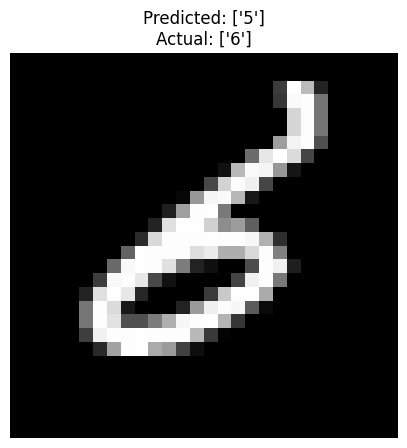

In [53]:
idx_mis = np.where(y_pred_bin!=y_test_bin)[0]
idx_test = np.random.choice(idx_mis, size=1)

plt.figure(figsize=(5,5));

sns.heatmap(np.reshape(X_test_bin[idx_test], (28,28)), cmap=plt.cm.gray,
             xticklabels=False, yticklabels=False, cbar=False);
plt.title("Predicted: %s\nActual: %s" % (y_pred_bin[idx_test],y_test_bin[idx_test]));

Now, let’s see how the SVC made its decision for this test point $\mathbf{x_t}$, by computing

$$w_0 + \sum_{i \in S} \alpha_i y_i \sum_{j=1}^p  x_{ij}, x_{tj}$$

where $S$ is the set of support vectors. (Recall that $\alpha_i = 0$ for any point that is not a support vector.)

First, we need the list of $i \in S$.

We use `support_` to get the indices of the support vectors (in the training set) and `n_support_` to get the number of support vectors for each class.

In [54]:
idx_support = cls_svc_bin.support_
print(idx_support.shape)
print(cls_svc_bin.n_support_)

(183,)
[89 94]


Next, for each class ($+$ and $-$), we will find:

-   the support vectors for that class, $x_i$  
-   the values of the dual coefficients $\alpha_i$ for each support vector for that class. Actually, the SVM model returns $\alpha_i y_i$, but that’s fine, too.

In [55]:
n_support_c1 = cls_svc_bin.n_support_[0]
idx_support_c1 = idx_support[0:n_support_c1]
dual_coef_c1 = cls_svc_bin.dual_coef_[:,0:n_support_c1]

In [56]:
n_support_c2 = n_support_c1 + cls_svc_bin.n_support_[1]
idx_support_c2 = idx_support[n_support_c1:n_support_c1+n_support_c2]
dual_coef_c2 = cls_svc_bin.dual_coef_[:, n_support_c1:n_support_c1+n_support_c2]

Now we have the dual coefficients!

A brief digression - recall that the dual SVC problem is

$$
\begin{aligned}
\max_\alpha \quad & \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j = 1}^{n} \alpha_i \alpha_j y_i y_j
\mathbf{x}_i^T \mathbf{x}_j \\
\text{s.t.} \quad & \sum_{i=1}^n \alpha_i y_i = 0, \quad 0 \leq \alpha_i \leq C, \quad \forall i
\end{aligned}
$$

so each $\alpha_i$ will be between $0$ and $C$.

But, the values in the `dual_coef_` array returned by the `sklearn` SVM model are not directly the $\alpha_i$. Instead, they are $\alpha_i y_i$, so:

-   the coefficients will be negative for the negative class and positive for the positive class, but
-   you should see that the magnitudes are always between $0$ and $C$.

In [57]:
dual_coef_c1

array([[-0.16712371, -0.10012183, -0.87929   , -0.00211268, -0.28524779,
        -0.06546673, -0.44507862, -0.450581  , -0.00273731, -0.3096143 ,
        -0.09271315, -0.19217344, -0.03462042, -0.17162157, -0.33745069,
        -0.05630417, -0.50619656, -0.14414538, -1.3806279 , -0.07431356,
        -0.18699448, -0.05547178, -0.03812882, -0.80433449, -0.23614225,
        -0.65487927, -1.0135382 , -0.06764535, -0.00521297, -0.34845786,
        -0.27154818, -0.1216201 , -0.26351182, -0.49216846, -0.63171837,
        -0.07673679, -0.00907738, -0.8084709 , -0.34889313, -0.15454186,
        -0.39583019, -0.72139646, -0.30054019, -0.27944657, -0.31071473,
        -1.17727624, -0.2280842 , -0.38052409, -0.28655475, -0.25193252,
        -0.38293757, -0.02086671, -0.15491527, -0.3108609 , -0.19467427,
        -0.61292806, -0.05676506, -0.32512181, -0.09677439, -0.48570507,
        -0.48137693, -0.00825446, -0.08379967, -0.42769055, -0.05766105,
        -0.21595822, -0.17141247, -0.09409865, -0.2

In [58]:
dual_coef_c2

array([[5.94191430e-02, 1.06907306e-01, 1.20252851e-01, 1.21666974e-01,
        4.92530044e-01, 2.78092664e-01, 2.02662454e-01, 5.62398461e-02,
        1.85371775e-01, 2.18107414e-01, 1.75392584e-01, 9.34869271e-01,
        1.71336188e-02, 2.02394946e-01, 6.83581498e-02, 1.57892871e-01,
        2.43295922e-01, 6.14754666e-01, 8.02039827e-01, 2.53577664e-01,
        2.70787168e-01, 1.74952723e-01, 3.75528286e-02, 9.60819276e-02,
        4.51351459e-01, 1.74756973e-01, 1.88805079e-01, 4.14454292e-01,
        7.54531809e-01, 1.31706677e-02, 1.42926311e-01, 1.50455118e-01,
        1.11006760e-01, 2.12464365e-01, 6.77929566e-02, 4.27593690e-02,
        9.47782115e-02, 8.94598614e-02, 1.81764822e-01, 2.69251790e-02,
        1.64562481e-01, 1.37017538e-01, 3.56599214e-02, 1.83782056e-01,
        3.13179638e-01, 1.56193904e-02, 7.72676630e-01, 1.36714716e-01,
        8.35154189e-01, 1.16019396e-01, 3.46918268e-01, 3.49211293e-01,
        9.65281262e-02, 6.34554359e-01, 7.43287824e-01, 1.944426

Note that the constraint $\sum_{i=1}^n \alpha_i y_i = 0$ is also satisfied:

In [59]:
np.sum(dual_coef_c1) + np.sum(dual_coef_c2)

0.0

Finally, we need $\mathbf{x}_i^T \mathbf{x}_{t}$ for each support vector $i$.

This is a measure of the similarity of the test point to each support vector, using the dot product as “similarity metric”.

We will compute this separately for the support vectors in the negative class and then for the support vectors in the positive class.

In [60]:
from sklearn.metrics.pairwise import pairwise_kernels
similarity = pairwise_kernels(X_train_bin, X_test_bin[idx_test].reshape(1, -1))
similarity_c1 = similarity[idx_support_c1].ravel()
similarity_c2 = similarity[idx_support_c2].ravel()

Now that we have $\alpha_i y_i$ and $\mathbf{x}_i^T \mathbf{x}_{t}$ for each support vector $i \in S$, we can compute

$$\sum_{i \in S} \alpha_i y_i \mathbf{x}_i^T \mathbf{x}_{t} $$

We’l do this separately for each class.

Here is the sum of

$$\sum_{i \in S^-} \alpha_i y_i \mathbf{x}_i^T \mathbf{x}_{t} $$

where $S^-$ is the set of support vectors for the negative class:

In [61]:
np.sum(similarity_c1*dual_coef_c1)

-878.7709122968098

And here is the sum of

$$\sum_{i \in S^+} \alpha_i y_i \mathbf{x}_i^T \mathbf{x}_{t} $$

where $S^+$ is the set of support vectors for the positive class:

In [62]:
np.sum(similarity_c2*dual_coef_c2)

879.4130860750242

We also need the value of the intercept, $w_0$:

In [63]:
cls_svc_bin.intercept_

array([-1.50408325])

For a given test sample, the prediction depends on the sign of the overall sum, plus the intercept $w_0$. If it is positive, the prediction will be '6', and if it is negative, the prediction will be '5'.

In [64]:
np.sum(similarity_c1*dual_coef_c1) + \
  np.sum(similarity_c2*dual_coef_c2) + \
  cls_svc_bin.intercept_

array([-0.86190947])

The SVC can be interpreted as a kind of weighted nearest neighbor, where each support vector is a “neighbor”, the dot product is the distance metric, and we weight the contribution of each neighbor to the overall classification using both the distance and the dual coefficient:

$$\sum_{i\in S} \alpha_i y_i  \mathbf{x}_i^T \mathbf{x}_{t}$$

For the test point we chose, we can see the similarity to the five most important support vectors in each class - the five with the greatest magnitude of $\alpha_i$.

In [65]:
n_sv = 5
sv_c1 = np.argsort(np.abs(dual_coef_c1)).ravel()[-n_sv:]
sv_c2 = np.argsort(np.abs(dual_coef_c2)).ravel()[-n_sv:]

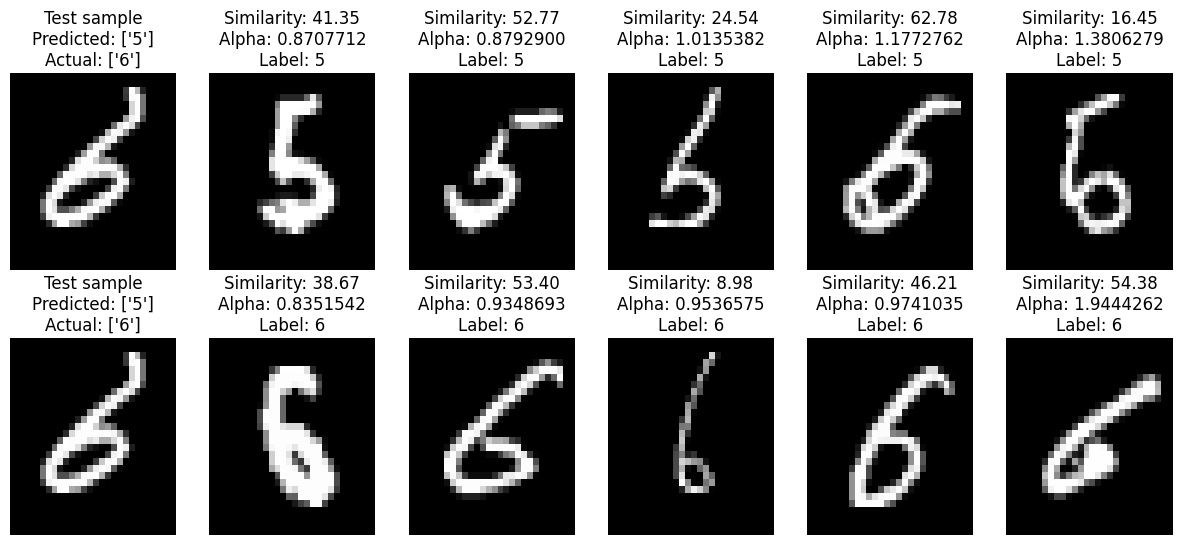

In [66]:
figure = plt.figure(figsize=(15,6));

plt.subplot(2, n_sv+1, 1);

sns.heatmap(np.reshape(X_test_bin[idx_test], (28,28)), cmap=plt.cm.gray,
             xticklabels=False, yticklabels=False, cbar=False);
plt.title("Test sample\nPredicted: %s\nActual: %s" % (y_pred_bin[idx_test],y_test_bin[idx_test]));

for i, idx in enumerate(sv_c1):
  plt.subplot(2, n_sv+1, i+1+1);
  sns.heatmap(np.reshape(X_train_bin[idx_support_c1[idx]], (28,28)), cmap=plt.cm.gray,
            xticklabels=False, yticklabels=False, cbar=False);
  plt.axis('off');
  plt.title("Similarity: %0.2f\nAlpha: %0.7f\nLabel: %s" % (similarity_c1[idx],
                                                            np.abs(dual_coef_c1.ravel()[idx]),
                                                            y_train_bin[idx_support_c1[idx]]));

plt.subplot(2, n_sv+1, n_sv+1+1);

sns.heatmap(np.reshape(X_test_bin[idx_test], (28,28)), cmap=plt.cm.gray,
             xticklabels=False, yticklabels=False, cbar=False);
plt.title("Test sample\nPredicted: %s\nActual: %s" % (y_pred_bin[idx_test],y_test_bin[idx_test]));

for i, idx in enumerate(sv_c2):
  plt.subplot(2, n_sv+1, n_sv+i+1+1+1);
  sns.heatmap(np.reshape(X_train_bin[idx_support_c2[idx]], (28,28)), cmap=plt.cm.gray,
            xticklabels=False, yticklabels=False, cbar=False);
  plt.axis('off');
  plt.title("Similarity: %0.2f\nAlpha: %0.7f\nLabel: %s" % (similarity_c2[idx],
                                                            np.abs(dual_coef_c2.ravel()[idx]),
                                                            y_train_bin[idx_support_c2[idx]]));

plt.subplots_adjust(hspace=0.35);
plt.show();

Can you see why these are the most “important” support vectors?

And, we can see the similarity to the five most similar support vectors in each class.

In [67]:
n_sv = 5
sv_c1 = np.argsort(np.abs(similarity_c1)).ravel()[-n_sv:]
sv_c2 = np.argsort(np.abs(similarity_c2)).ravel()[-n_sv:]

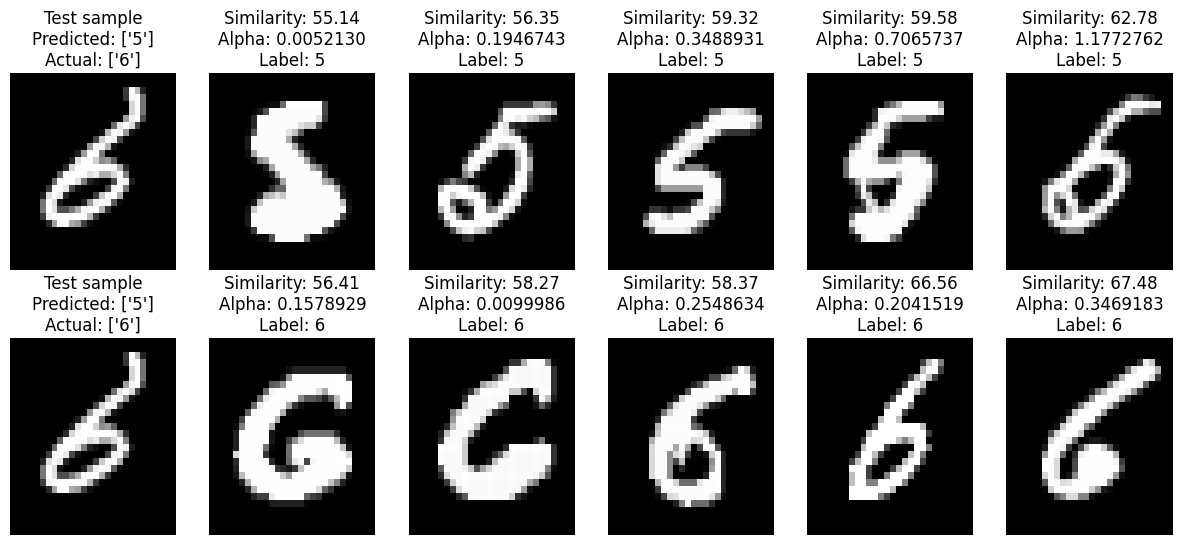

In [68]:
figure = plt.figure(figsize=(15,6));

plt.subplot(2, n_sv+1, 1);

sns.heatmap(np.reshape(X_test_bin[idx_test], (28,28)), cmap=plt.cm.gray,
             xticklabels=False, yticklabels=False, cbar=False);
plt.title("Test sample\nPredicted: %s\nActual: %s" % (y_pred_bin[idx_test],y_test_bin[idx_test]));

for i, idx in enumerate(sv_c1):
  plt.subplot(2, n_sv+1, i+1+1);
  sns.heatmap(np.reshape(X_train_bin[idx_support_c1[idx]], (28,28)), cmap=plt.cm.gray,
            xticklabels=False, yticklabels=False, cbar=False);
  plt.axis('off');
  plt.title("Similarity: %0.2f\nAlpha: %0.7f\nLabel: %s" % (similarity_c1[idx],
                                                            np.abs(dual_coef_c1.ravel()[idx]),
                                                            y_train_bin[idx_support_c1[idx]]));

plt.subplot(2, n_sv+1, n_sv+1+1);

sns.heatmap(np.reshape(X_test_bin[idx_test], (28,28)), cmap=plt.cm.gray,
             xticklabels=False, yticklabels=False, cbar=False);
plt.title("Test sample\nPredicted: %s\nActual: %s" % (y_pred_bin[idx_test],y_test_bin[idx_test]));

for i, idx in enumerate(sv_c2):
  plt.subplot(2, n_sv+1, n_sv+i+1+1+1);
  sns.heatmap(np.reshape(X_train_bin[idx_support_c2[idx]], (28,28)), cmap=plt.cm.gray,
            xticklabels=False, yticklabels=False, cbar=False);
  plt.axis('off');
  plt.title("Similarity: %0.2f\nAlpha: %0.7f\nLabel: %s" % (similarity_c2[idx],
                                                            np.abs(dual_coef_c2.ravel()[idx]),
                                                            y_train_bin[idx_support_c2[idx]]));

plt.subplots_adjust(hspace=0.35);
plt.show();

The support vector classifier at first seems a lot like the logistic regression, because it also learns a linear decision boundary. But, with the correlation interpretation, you can think of it as a kind of nearest neighbor classifier as well!